In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import copy
import torch
import csv
from abc_env import ABC_env
from naive_agents import DoNothing, FixedPhi
#from dynamic_phi_agent import DynamicPhiAgent
from actor_physicists_abc import RL_phi_agent

In [2]:
# PARAMS
A = 1.
B = 0.7
C = 0.43
NU = 0.99
kappa = 0.001
BETA = 0.1
baseline_phi = 0.4
D = 0.1 # placeholder for now
dims = 3

In [31]:
def compare_agents(agent_list,identfiers, sep_size=0.5,num_eps=100,time_horizon=10.):
    label_index=0
    labels=[]
    colors = ["C2","C1"]
    agent_number=0
    
    for agent in agent_list:
        env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
        env.limit = time_horizon
        cum_rew=np.zeros(int(env.limit/env.deltaT))
        for i in range(0,num_eps):
            time_step=0
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                #if type(agent)==RL_phi_agent:
                #    action=agent.sample_deterministic_action(env.getState())
                #else:
                #    action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
                cum_rew[time_step] += episode_rew
                time_step += 1
            #if env.dist() > 0.5:
            #    print("Catastrophic failure:")
            #    print(episode_rew)
            env.reset()
        if agent_number%2 == 0:
            plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps,f"{colors[agent_number//2]}")
        else:
            plt.plot(np.arange(len(cum_rew))/(1/env.deltaT),cum_rew/num_eps, f"{colors[agent_number//2]}--")
        labels.append(identfiers[label_index])
        label_index+=1
        agent_number +=1
    
        
    plt.legend(labels)
    plt.title(f"Avg Cumalative Reward")
    plt.xlabel("episode time")
    plt.ylabel("reward")

In [32]:
def compare_agents_avg_return(agent_list,identfiers, sep_size=0.2*np.pi,num_eps=100,time_horizon=10.):
    final_summed_rewards = []
    agent_episode_rewards = {}
    agent_id = 0
    
    for agent in agent_list:
        agent_episode_rewards[identfiers[agent_id]] = []
        env = ABC_env(A,B,C,sep_size,BETA,kappa,D,NU)
        env.limit = time_horizon
        summed_rew = 0
        for i in range(0,num_eps):
            episode_rew=0
            while not env.isOver():
                action=agent.sample_action(env.getState())
                reward = env.step(action)
                episode_rew += reward
            agent_episode_rewards[identfiers[agent_id]].append(episode_rew)
            summed_rew += episode_rew
            env.reset()
        final_summed_rewards.append(summed_rew)
        agent_id += 1
        
        
        
    print(f"Average rewards over {num_eps} episodes:\n")
    for i in range(len(identfiers)):
        name = identfiers[i]
        avg_rew = final_summed_rewards[i]/num_eps
        print(f"{name:<15} {avg_rew:.5f}")
    
    
    return agent_episode_rewards

In [5]:
phis = [0.6,1.1,1.6,2.1]
agents = []
identifiers = []
for phi in phis:
    fixed_phi = FixedPhi(phi)
    name = f"fixed_{phi}"
    agents.append(fixed_phi)
    identifiers.append(name)
    
    trained = RL_phi_agent(dims,action_scale=5.)
    trained.load_policy(f"saved_models/abc_env_{phi}_10.0.pt")
    trained_name = f"RL_trained_{phi}"
    agents.append(trained)
    identifiers.append(trained_name)
    
sampled_rewards = compare_agents_avg_return(agents,identifiers,num_eps=1000)

Average rewards over 1000 episodes:

fixed_0.6       -0.40784
RL_trained_0.6  -0.34884
fixed_1.1       -0.32381
RL_trained_1.1  -0.36321
fixed_1.6       -0.40041
RL_trained_1.6  -0.31272
fixed_2.1       -0.49141
RL_trained_2.1  -0.34564


In [33]:
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{1.1}_10.0.pt")
agents = [FixedPhi(1.1),trained]
identifiers = ["fixed_1.1","trained_1.1"]
sampled_rewards_single = compare_agents_avg_return(agents,identifiers,num_eps=1000)

Average rewards over 1000 episodes:

fixed_1.1       -0.32299
trained_1.1     -0.37577


fixed_0.6
RL_trained_0.6
fixed_1.1
RL_trained_1.1
fixed_1.6
RL_trained_1.6
fixed_2.1
RL_trained_2.1


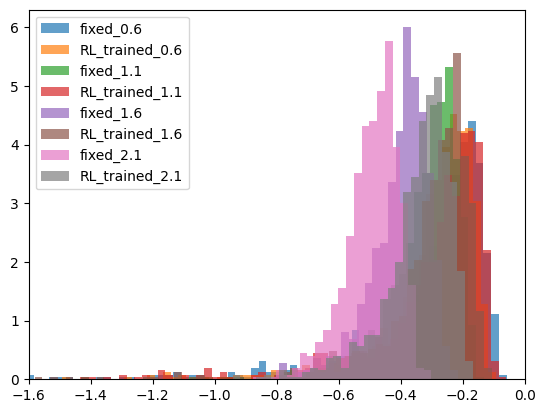

In [10]:
binwidth = 0.025
labels = []
for agent,rewards in sampled_rewards.items():
    plt.hist(rewards,bins=np.arange(min(rewards), max(rewards) + binwidth, binwidth),density=True,alpha=0.7)
    labels.append(agent)
    plt.xlim(-1.6,0)
plt.legend(labels=labels)

Text(0, 0.5, 'probability')

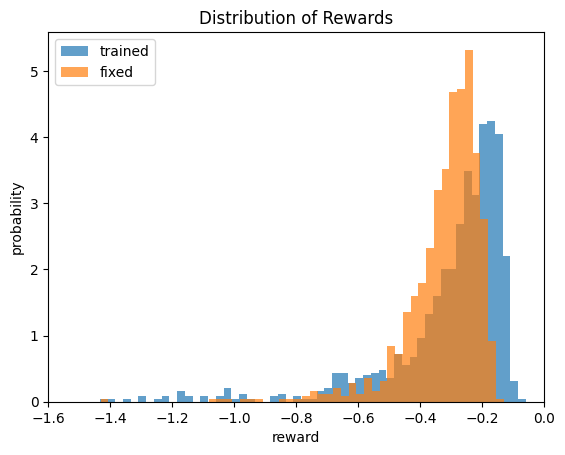

In [89]:
binwidth = 0.025
plt.hist(sampled_rewards["RL_trained_1.1"],bins=np.arange(min(sampled_rewards["RL_trained_1.1"]), max(sampled_rewards["RL_trained_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.xlim(-1.6,0)
plt.legend(labels=["trained","fixed"])
plt.title("Distribution of Rewards")
plt.xlabel("reward")
plt.ylabel("probability")

In [9]:
with open(f'csv/abc_results_params{A},{B},{C},{BETA},{kappa},{D},{NU}.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=list(sampled_rewards.keys()))
    writer.writeheader()
    writer.writerow(sampled_rewards)

In [ ]:
assert(1==0)

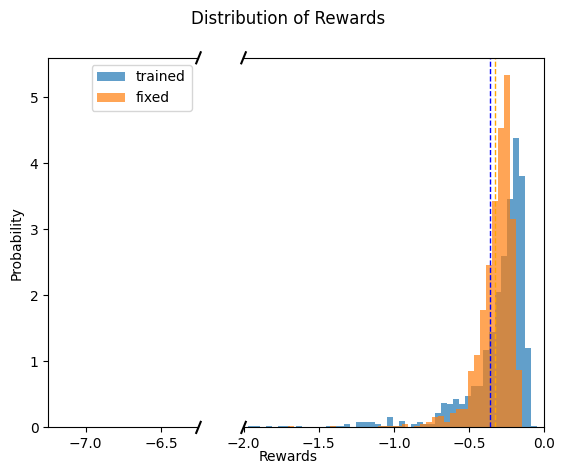

In [124]:
binwidth=0.04
fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w',gridspec_kw={'width_ratios': [1, 2]})

# plot the same data on both axes

ax.hist(sampled_rewards["RL_trained_1.1"],bins=np.arange(min(sampled_rewards["RL_trained_1.1"]), max(sampled_rewards["RL_trained_1.1"]) + 2*binwidth, 2*binwidth),density=True,alpha=0.7)
ax.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + 2*binwidth, 2*binwidth),density=True,alpha=0.7)
ax2.hist(sampled_rewards["RL_trained_1.1"],bins=np.arange(min(sampled_rewards["RL_trained_1.1"]), max(sampled_rewards["RL_trained_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
ax2.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)


# Calculate average value
fixed_mean = np.mean(sampled_rewards["fixed_1.1"])
agent_mean = np.mean(sampled_rewards["RL_trained_1.1"])

# Plot vertical line at the average value
ax2.axvline(fixed_mean, color='orange', linestyle='dashed', linewidth=1)
ax2.axvline(agent_mean, color='blue', linestyle='dashed', linewidth=1)

# Add label for the average value
ax2.text(fixed_mean+2*binwidth, ax2.get_ylim()[1]*0.5, f'', color='black', fontsize=10, ha='right', rotation=90)
ax2.text(agent_mean, ax2.get_ylim()[1]*0.5, f'', color='black', fontsize=10, ha='right', rotation=90)

ax.legend(labels=["trained","fixed"])
ax.set_xlim(-7.25, -6.25)
ax2.set_xlim(-2., 0.)


ax2.get_yaxis().set_visible(False)
ax2.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)




"""
# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.get_yaxis().set_visible(False)
ax.yaxis.tick_left()
ax.tick_params(labelright='off')
ax2.yaxis.tick_right()
"""
# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0, 0), (0, 1),
# (1, 0), and (1, 1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d, 1+d), (-d, +d), **kwargs)
ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d/2, +d/2), (1-d, 1+d), **kwargs)
ax2.plot((-d/2, +d/2), (-d, +d), **kwargs)

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax.set_ylabel("Probability")
fig.suptitle('Distribution of Rewards')
fig.text(0.5, 0.04, 'Rewards', ha='center')
plt.show()

Text(0.5, 1.0, 'Distribution of Rewards')

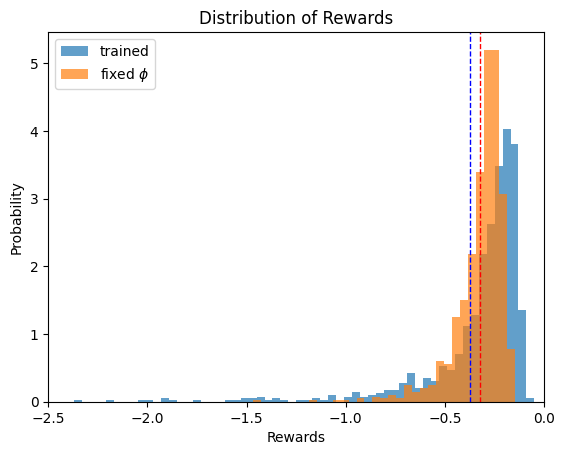

In [41]:
sampled_rewards = sampled_rewards_single
# Calculate average value
fixed_mean = np.mean(sampled_rewards["fixed_1.1"])
agent_mean = np.mean(sampled_rewards["trained_1.1"])


plt.hist(sampled_rewards["trained_1.1"],bins=np.arange(min(sampled_rewards["trained_1.1"]), max(sampled_rewards["trained_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.hist(sampled_rewards["fixed_1.1"],bins=np.arange(min(sampled_rewards["fixed_1.1"]), max(sampled_rewards["fixed_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.legend(labels=["trained","fixed $\phi$"])
# Plot vertical line at the average value
plt.axvline(fixed_mean, color='red', linestyle='dashed', linewidth=1)
plt.axvline(agent_mean, color='blue', linestyle='dashed', linewidth=1)

plt.xlim(-2.5,0)
plt.xlabel("Rewards")
plt.ylabel("Probability")
plt.title("Distribution of Rewards")

In [95]:
np.mean(sampled_rewards["fixed_1.1"])

-0.323808610525705

In [96]:
np.mean(sampled_rewards["RL_trained_1.1"])

-0.36321216644500837

In [14]:
type(fixed_phi) == RL_phi_agent

False

In [ ]:
baseline_phi = 1.1
fixed_phi = FixedPhi(baseline_phi) # need to retune
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{baseline_phi}_10.0.pt")
compare_agents([ trained , fixed_phi],
              ["trained_suboptimal", "fixed_phi_suboptimal"],time_horizon=10.0,#,"trained_rescaled_baseline"],#"phi=2.7"],
               #1,
              num_eps=100)

In [72]:
test_agent = RL_phi_agent(dims,action_scale=5.)
test_agent.load_policy(f"saved_models/abc_env_{1.5}_10.0.pt")
env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
env.limit = 10.import julia
jl = julia.Julia(compiled_modules=False)
from julia import Main
import numpy as  np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
final_rewards1=[]
actions = []
for i in range(0,1000):
    time_step=0
    reward = 0 
    while not env.isOver():
        action=test_agent.sample_action(env.getState())
        reward += env.step(action)
        actions.append(action)
    final_rewards1.append(reward)
    env.reset()

In [82]:
fixed_phi = FixedPhi(1.5) # need to retune
env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
env.limit = 10.
final_rewards=[]
actions = []
for i in range(0,1000):
    time_step=0
    reward = 0 
    while not env.isOver():
        action=fixed_phi.sample_action(env.getState())
        reward += env.step(action)
        actions.append(action)
    final_rewards.append(reward)
    env.reset()

In [115]:
plt.hist(final_rewards1,bins=500,density=True,alpha=0.7)
plt.hist(final_rewards,bins=50,density=True,alpha=0.7)
plt.legend(labels=["trained_agent","fixed_agent"])
plt.xlim(-1.6,0)

NameError: name 'final_rewards1' is not defined

(-1.6, 0.0)

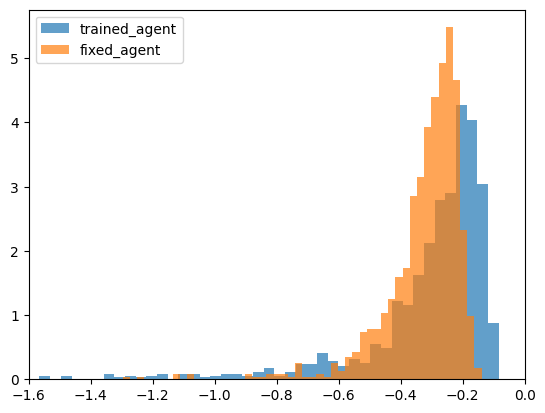

In [71]:
plt.hist(final_rewards1,bins=500,density=True,alpha=0.7)
plt.hist(final_rewards,bins=50,density=True,alpha=0.7)
plt.legend(labels=["trained_agent","fixed_agent"])
plt.xlim(-1.6,0)

### Compare vs hybrid technique

In [ ]:
#TODO
# import stable base classes
# load trained out of box methods
# run num_eps
# plot evolution of avg reward over an episode of out of box methods vs fixed vs our RL
# Actually done in train of out of box

In [4]:
phi_star=1.1
def compare_agents_avg_return_hybrid(agent_list,identfiers, sep_size=0.2*np.pi,num_eps=100,time_horizon=10.):
    final_summed_rewards = []
    agent_episode_rewards = {}
    agent_id = 0
    disasters_ad=[]
    intervention_length = 10
    
    for agent in agent_list:
        agent_episode_rewards[identfiers[agent_id]] = []
        env = ABC_env(A,B,C,sep_size,BETA,kappa,D,NU)
        env.limit = time_horizon
        summed_rew = 0
        for i in range(0,num_eps):
            advantages = []
            episode_rew=0
            intervention_counter = intervention_length
            while not env.isOver():
                
                intervention = np.mean(advantages[-10:]) < -0.01 and env.time_step>5 # arbitrary threshold and window size
                if (intervention):
                    intervention_counter=0
                if((intervention or intervention_counter<intervention_length) and identfiers[agent_id]=="hybrid"):
                    action=phi_star
                    intervention_counter+=1
                else:
                    action=agent.sample_action(env.getState())
                
                curr_val = env.eval_step(phi_star)
                reward = env.step(action)
                new_val = env.eval_step(phi_star)
                advantage = reward + curr_val - new_val
                advantages.append(advantage)
                episode_rew += reward
            agent_episode_rewards[identfiers[agent_id]].append(episode_rew)
            summed_rew += episode_rew
            env.reset()
            if (episode_rew<-1.0):
                disasters_ad.append(advantages)
        final_summed_rewards.append(summed_rew)
        agent_id += 1
        
        
        
        
    print(f"Average rewards over {num_eps} episodes:\n")
    for i in range(len(identfiers)):
        name = identfiers[i]
        avg_rew = final_summed_rewards[i]/num_eps
        print(f"{name:<15} {avg_rew:.5f}")
        
    #debugging
    #window_size=10
    #plt.plot(np.convolve(advantages, np.ones(window_size)/window_size, mode='valid'))
        
    return agent_episode_rewards, disasters_ad

In [15]:
trained = RL_phi_agent(dims,action_scale=5.)
trained.load_policy(f"saved_models/abc_env_{1.6}_10.0.pt")
agents = [trained,trained,FixedPhi(1.1)]
identifiers = ["trained_1.6","hybrid","fixed_1.1"]
sampled_rewards_single,disaster_ad = compare_agents_avg_return_hybrid(agents,identifiers,num_eps=500)

Average rewards over 500 episodes:

trained_1.6     -0.32071
hybrid          -0.31594
fixed_1.1       -0.32700


Text(0.5, 1.0, 'Distribution of Rewards')

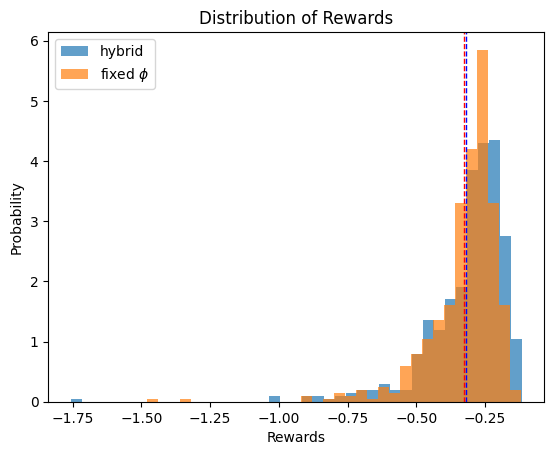

In [23]:
binwidth=0.04
fixed_mean = np.mean(sampled_rewards_single["fixed_1.1"])
agent_mean = np.mean(sampled_rewards_single["trained_1.6"])

plt.hist(sampled_rewards_single["hybrid"],bins=np.arange(min(sampled_rewards_single["hybrid"]), max(sampled_rewards_single["hybrid"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.hist(sampled_rewards_single["fixed_1.1"],bins=np.arange(min(sampled_rewards_single["fixed_1.1"]), max(sampled_rewards_single["fixed_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
#plt.hist(sampled_rewards_single["trained_1.1"],bins=np.arange(min(sampled_rewards_single["trained_1.1"]), max(sampled_rewards_single["trained_1.1"]) + binwidth, binwidth),density=True,alpha=0.7)
plt.legend(labels=["hybrid",r"fixed $\phi$","trained"])
#plt.xlim(-2.,0.)
#plt.xlim(-10,-7.)
#plt.ylim(0,0.1)
plt.axvline(fixed_mean, color='red', linestyle='dashed', linewidth=1)
plt.axvline(agent_mean, color='blue', linestyle='dashed', linewidth=1)

plt.xlabel("Rewards")
plt.ylabel("Probability")
plt.title("Distribution of Rewards")

In [262]:
max(sampled_rewards_single["trained_1.1"])

-0.09020946843944855

In [226]:
disaster_ad

[[-0.011885330721211312,
  -0.03766864241489207,
  -0.013506223827895764,
  -0.017259373823740487,
  -0.016398000892780068,
  -0.027900887392171808,
  -0.012055407101705967,
  0.004311571359417649,
  -0.018746158179319627,
  0.0001463400593239017,
  -0.02793506472699059,
  -0.013695665007549707,
  -0.012493909594024855,
  -0.061498026530105776,
  -0.020934416163206404,
  -0.028301133831283687,
  -0.014191583616419756,
  -0.021843379463092394,
  -0.01091325942512289,
  -0.04821288387565403,
  0.0013629384549144752,
  -0.045366978902147415,
  -0.008237375663523838,
  -0.002141977740790668,
  -0.050568863548710485,
  -0.020194011970216308,
  -0.03430365193760054,
  -0.04329106648187869,
  -0.02543047680236471,
  -0.012157022631947123,
  -0.04653482505770129,
  -0.026270036203650593,
  -0.06982602089311601,
  -0.03827914610185551,
  -0.061983800159092994,
  -0.06771344867199297,
  -0.046760230269367764,
  -0.03180427031254118,
  -0.048725745188914066,
  -0.040509711968169854,
  -0.03752928

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 59., 39.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  5., 14., 62., 18.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 55., 41.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 79., 18.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  6., 42., 52.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 58., 39.],
        [ 0.,  0.,  0.,  0.,  2.,  6.,  7.,  8., 51., 26.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 83., 16.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  3., 83., 14.],
        [ 0.,  1.,  5.,  3.,  6.,  6., 13., 15., 46.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2., 25., 68.,  5.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 74., 26.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 81., 19.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 73., 26.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 71., 25.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., 78., 21.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  

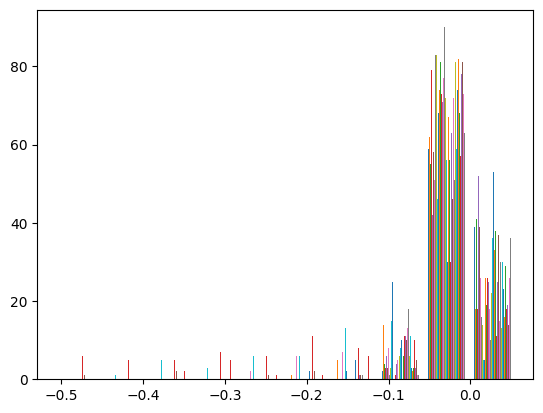

In [235]:
plt.hist(disaster_ad)

In [228]:
success_ad

[[-0.06470874061051524,
  -0.048965955989556054,
  -0.03810754373104053,
  -0.02596888437662942,
  -0.029512119316212504,
  -0.020159988106907722,
  -0.025502757672001566,
  -0.008483749603441462,
  -0.01570485092518213,
  -0.00792981384536949,
  -0.005334988934489342,
  -0.0026002630592503653,
  -0.005596628613094284,
  -0.0005495934989771453,
  -0.00217737020162359,
  -0.00032518688735576513,
  -0.0009706974311828875,
  0.00035464119432238993,
  -0.0006397939444059992,
  -0.0017813116981467113,
  0.000630515011692998,
  0.0009160202977940078,
  0.0006701289299482242,
  -0.0012643389328887578,
  0.000234233590035719,
  -0.0011250120171663975,
  -0.00023191269932237857,
  0.0007778697440976399,
  -0.0003867249090524975,
  -0.0008142115156094848,
  -0.00024693316155260676,
  -0.0005399026577546074,
  -8.994335939930924e-05,
  0.000583555213351248,
  -0.0005313232602253293,
  -0.0006076701197906247,
  0.000524647400275659,
  0.000825479841478897,
  -0.0013782340239895693,
  0.00077212823

(array([[ 0.,  0.,  0., ...,  4.,  5., 88.],
        [ 0.,  0.,  0., ...,  4.,  6., 85.],
        [ 0.,  0.,  0., ...,  4., 14., 78.],
        ...,
        [ 0.,  1.,  0., ...,  3.,  3., 90.],
        [ 0.,  0.,  1., ...,  2.,  6., 88.],
        [ 0.,  1.,  0., ...,  2.,  3., 91.]]),
 array([-0.11897085, -0.10621432, -0.09345779, -0.08070125, -0.06794472,
        -0.05518818, -0.04243165, -0.02967512, -0.01691858, -0.00416205,
         0.00859449]),
 <a list of 278 BarContainer objects>)

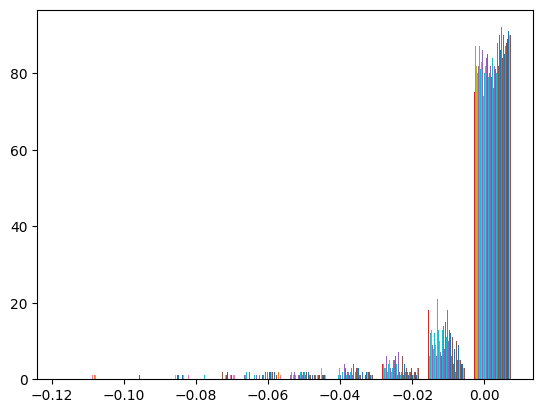

In [229]:
plt.hist(success_ad)

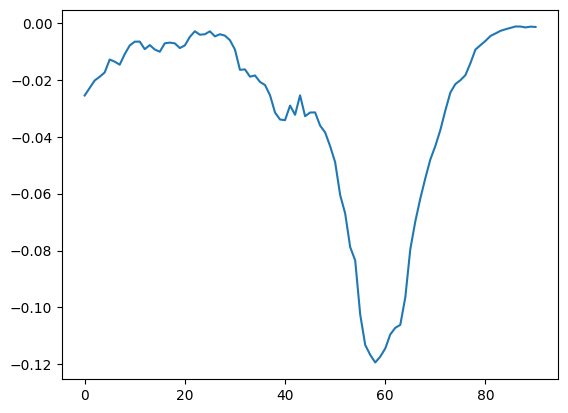

In [237]:
window_size=10
plt.plot(np.convolve(disaster_ad[1], np.ones(window_size)/window_size, mode='valid'))

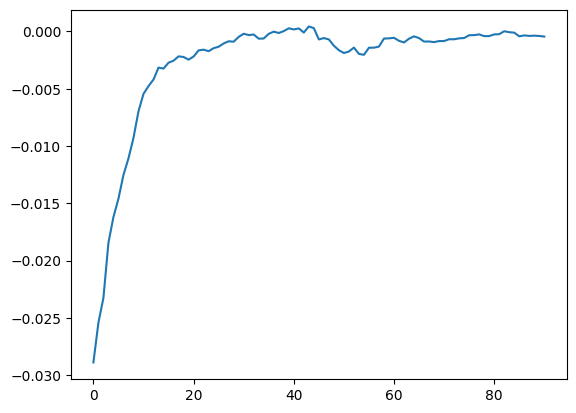

In [222]:
plt.plot(np.convolve(success_ad[4], np.ones(window_size)/window_size, mode='valid'))

In [173]:
x=[1,2,3]
np.mean([])<-0.1

False

In [3]:
#def sync_env(real_env,dummy_env)
env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
dummy_env = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)
dummy2 = ABC_env(A,B,C,0.2*np.pi,BETA,kappa,D,NU)

In [25]:
phi=1.1
agent = RL_phi_agent(dims,action_scale=5.)
agent.load_policy(f"saved_models/abc_env_{phi}_10.0.pt")

interesting_eps=False
while not interesting_eps:
    a_traj = []
    do_nothing = []
    weak_phi = []
    
    RL_cum_rew=0
    while not env.isOver():
        a_traj.append(env.getState())
        do_nothing.append(dummy_env.getState())
        weak_phi.append(dummy2.getState())


        RL_cum_rew += env.step(agent.sample_action(env.getState()))
        dummy_env.step(0.)
        dummy2.step(phi)


        dummy_env.passive = env.passive
        dummy2.passive = env.passive

    env.reset()
    dummy_env.reset()
    dummy2.reset()
    
    if RL_cum_rew > -.1:
        interesting_eps = True

    

a_traj = np.array(a_traj) 
do_nothing = np.zeros(np.array(do_nothing).shape)
weak_phi = np.array(weak_phi) 
    

In [26]:

fig = go.Figure()


fig.add_trace(go.Scatter3d(
    x=a_traj[:,0],
    y=a_traj[:,1],
    z=a_traj[:,2],
    mode='lines',
    name="actor-_physicists trajectory"
))

fig.add_trace(go.Scatter3d(
    x=do_nothing[:,0],
    y=do_nothing[:,1],
    z=do_nothing[:,2],
    mode='lines',
    name="do_nothing trajectory"
))

fig.add_trace(go.Scatter3d(
    x=weak_phi[:,0],
    y=weak_phi[:,1],
    z=weak_phi[:,2],
    mode='lines',
    name="weak_phi trajectory"
))

In [27]:

# Create the initial figure
fig = go.Figure()



fig.add_trace(go.Scatter3d(
    x=weak_phi[:,0],
    y=weak_phi[:,1],
    z=weak_phi[:,2],
    mode='lines',
    name="weak_phi trajectory"
))

# Add the active trajectory
fig.add_trace(go.Scatter3d(
    x=a_traj[:, 0] ,
    y=a_traj[:, 1] ,
    z=a_traj[:, 2] ,
    mode='lines',
    name="Active trajectory"
))

# Add the do_nothing trajectory
fig.add_trace(go.Scatter3d(
    x=do_nothing[:, 0] ,
    y=do_nothing[:, 1] ,
    z=do_nothing[:, 2] ,
    mode='lines',
    name="Do_nothing trajectory"
))

# Define frames for the animation
frames = []
for i in range(len(a_traj)):
    frame = go.Frame(
        data=[
            go.Scatter3d(
                x=weak_phi[:i+1, 0] ,
                y=weak_phi[:i+1, 1] ,
                z=weak_phi[:i+1, 2] ,
                mode='lines',
                name="weak_phi trajectory"
            ),
            go.Scatter3d(
                x=a_traj[:i+1, 0] ,
                y=a_traj[:i+1, 1] ,
                z=a_traj[:i+1, 2] ,
                mode='lines',
                name="Active trajectory"
            ),
            go.Scatter3d(
                x=do_nothing[:i+1, 0] ,
                y=do_nothing[:i+1, 1] ,
                z=do_nothing[:i+1, 2] ,
                mode='lines',
                name="Do_nothing trajectory"
            )
        ],
        name=str(i),
        layout=go.Layout(title_text=f"Frame {i}")
    )
    frames.append(frame)

# Add frames to the animation
fig.frames = frames

# Create slider steps
slider_steps = []
for i in range(len(a_traj)):
    step = {"args": [[str(i)], {"frame": {"duration": 200, "redraw": True}, "mode": "immediate", "transition": {"duration": 300}}],
            "label": str(i),
            "method": "animate"}
    slider_steps.append(step)

# Create slider
sliders = [dict(
    active=0,
    currentvalue={"prefix": "Frame: "},
    pad={"t": 50},
    steps=slider_steps
)]

# Update layout with sliders
fig.update_layout(
    sliders=sliders
)

fig.show()